# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ";") # import (Summary of feature attributes for demographics data) dataset using a semicolon separator
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ";") # import ( Summary of feature attributes for demographics data) dataset using a semicolon separator

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

- Here we explore the general demographics data

In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
# explore a random sample of our dataset
azdias.sample(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
747418,-1,3,2,6.0,2,2,3,2,3,4,...,1.0,4.0,2.0,1.0,5.0,4.0,3.0,4.0,9.0,4.0
789869,-1,2,1,3.0,2,5,2,4,4,3,...,1.0,4.0,3.0,1.0,3.0,3.0,2.0,4.0,7.0,5.0
434388,-1,3,1,4.0,5,2,4,2,2,1,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,2.0
502654,-1,1,1,6.0,2,5,3,5,4,2,...,4.0,1.0,0.0,0.0,1.0,2.0,3.0,1.0,3.0,1.0
522307,2,4,1,2.0,5,2,4,3,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Here we explore the feature summary file

In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ANZ_PERSONEN,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
# explore a random sample of our dataset
feat_info.sample(15)

,attribute,information_level,type,missing_or_unknown
13,GREEN_AVANTGARDE,person,categorical,[]
19,LP_STATUS_FEIN,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
56,WOHNLAGE,building,mixed,[-1]
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
65,KBA05_GBZ,microcell_rr3,ordinal,"[-1,0]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
10,FINANZTYP,person,categorical,[-1]
36,SEMIO_PFLICHT,person,ordinal,"[-1,9]"


In [10]:
len(feat_info) # print the number of rows for our feat_info df

85

In [11]:
feat_info # here lets take a look at the dataframe reviewing the row and column values

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

- Here after explorting the feature summary dataframe in conjunction with reviewing the data dictionary we determine that the column missing_or_unknown identifies the values that are associted with missing or unknown values in our general demographic dataset [azdias]. Here we will need to split the data values contained in missing_or_unknown for each attribue that corrisponds to a column in [azdias] then if the values match we will replace the value in [azdias] with NAN.

- Here we explore the data contained in our split missing/unknown columns

In [12]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [13]:
#here we print the total number of Null values per column
missing_before_update = azdias.isna().sum().sum()
print(missing_before_update)

4896838


In [14]:
feat_info.missing_or_unknown.value_counts() # print the unique combination of the data in missing_or_unknown with totals

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[-1,XX]      1
[XX]         1
Name: missing_or_unknown, dtype: int64

- Here for each column in our azdias we loop through our feature info dataset replacing the values that are missing or null with NaN.
- Here we clean our assesment above to split the data contained in the missing_or_unknown column in our feature dataset using the split funtion. Following these steps to complete this process. First we loop through our dataset over each row. we assign our variable missing_or_unknown with the column's value, then we strip the list indicators '[' & ']' from our variable. Next we use pythons split function to split the variable with a comma separator which we we found in our exploration of the columns deatils above using the value_count function. Next the columns contains both integer as well as string values (X,XX, and blank ''). Finally after converting numeric values to integers we review if our variable has data here If missing_or_unknown then replace the data in our demographic dataset with NaN completing our udpates for idetified missing data.

In [15]:
for idx, row in feat_info.iterrows():
    missing_or_unknown = row['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[]') # remove [ ] from string
    missing_or_unknown = missing_or_unknown.split(',') # split values with , sep  
    missing_or_unknown = [int(value) if value not in {'X', 'XX', ''} else value # Convert each value to int if it's not 'X', 'XX', or an empty string
                          for value in missing_or_unknown]
    if missing_or_unknown:     # If the list is not empty, replace the corresponding values in azdias with NaN
        attr_name = row['attribute']
        azdias = azdias.replace({attr_name: missing_or_unknown}, np.nan)

- Here we get the total of missing values from our demographic dataset after identifying and replacing the unknown and missing datapoint with NaN.

In [16]:
#here we print the total number of Null values per column
missing_after_update = azdias.isna().sum().sum()
print('Total Number of Replacements after Updates', missing_after_update - missing_before_update)

Total Number of Replacements after Updates 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

- Here we review our demographic dataset. For each column in our data we determine the total number of columns that have missing or null data. We create a rate amount for each column which is the total number of null values for the column as the numerator and the total number of rows. Next we determine which columns have missing data and append this information to a new dataframe that we can use to store the column details along with the null rate for each columns.

In [17]:
# Investigate patterns in the amount of missing data in each column.

In [18]:
a_list = []
b_list = []
for col in azdias.columns:
    null_rows = azdias[col].isna().sum()
    null_rate = round(null_rows / len(azdias) * 100)
    if null_rate > 0:
        a_list.append(col)
        b_list.append(null_rate)
df = pd.DataFrame({'Column_Name': a_list, 'Null_Rate': b_list})    
del a_list, b_list

- Here we explore our new dataframe to identify columns that have a large Null Rate here we sort the values to so the outliers first that we can use to determine which columns should be removed from our demographic dataset.

In [19]:
df.sort_values(by='Null_Rate', ascending=False)

,Column_Name,Null_Rate
16,TITEL_KZ,100.0
0,AGER_TYP,77.0
22,KK_KUNDENTYP,66.0
39,KBA05_BAUMAX,53.0
2,GEBURTSJAHR,44.0
18,ALTER_HH,35.0
45,KKK,18.0
48,REGIOTYP,18.0
23,W_KEIT_KIND_HH,17.0
36,KBA05_ANTG2,15.0


- Here we use plot to visualize our Null Data distrubution

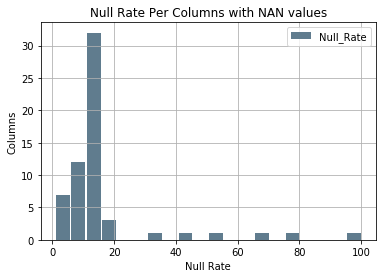

In [20]:
df.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Null Rate Per Columns with NAN values')
plt.xlabel('Null Rate')
plt.ylabel('Columns')
plt.grid(axis='y', alpha= 1)

- After reviewing the Null_Rate for our columns we can see a the columns that have a high rate of null values. We have made the determination looking into our data that the columns that contain over 20% Null data should be removed from our dataset. Next we will loop through our dataset and drop these columns.
- Here we corrected our original review which had a threshold of 60% of missing values.

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [22]:
for i in range(len(df)): # for each row in our missing column rates dataframe if the rate is > 20 lets drop the column
    a = df['Column_Name'][i]
    if df['Null_Rate'][i] > 20:
        print('Dropped Column:', a)
        azdias.drop(a, axis=1, inplace = True)

Dropped Column: AGER_TYP
Dropped Column: GEBURTSJAHR
Dropped Column: TITEL_KZ
Dropped Column: ALTER_HH
Dropped Column: KK_KUNDENTYP
Dropped Column: KBA05_BAUMAX


- Here we verify our column has been dropped

In [23]:
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column

- In the section we reviewed all of the columns details for our demographic dataset. We created a new dataframe to store the columns that had NULL data present. We then viewed the results showing the NULL rate for each column that contained NULL data. Here we pritned the extact totals and sorted by the NULL rate in descending order to show the columns with the highest rates to lowest. We then created a histrogram to visually represent the distrubtion of NULL rates amongst our columns with NULL data. Finally we landed on removing columns (AGER_TYP, GEBURTSJAHR TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX) from our dataset where the NULL rate was greater than 20%, identifying these as our outlier columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

- Here before we make updates to our main original dataset we create a copy to work with.

In [24]:
df1 = azdias.copy() # Create a copy of the original dataset

- Here in our copy of our demographic dataset we create a new column full_count which will be populated for each row in our dataset. We will store the number of columns that have data and non NULL values in this column. Here a value of 85 means all of the columns in this row have data and no NULL values are represented in the rows columns, alternitivley if column full_count stores a 3 this means that only 3 of the 85 columns have values other than NULL.

In [25]:
df1['full_count'] = df1.apply(lambda x: x.count(), axis=1) # create a column for each row to identify missing values per row

In [26]:
# How much data is missing in each row of the dataset?
print('Total Missing Values', df1['full_count'].sum())

Total Missing Values 65371155


- Here we explore the dataset. Reviewing our new column full_count to get and verify how the data is populated for this field.

In [27]:
df1.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,full_count
762203,3.0,2,5.0,2,3,3,4,1,4,6,...,4.0,3.0,1.0,3.0,4.0,3.0,4.0,6.0,3.0,79
317740,4.0,1,1.0,5,1,5,1,1,2,6,...,2.0,1.0,0.0,1.0,3.0,3.0,3.0,4.0,3.0,79
59114,1.0,2,3.0,2,5,3,5,5,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,63
665489,4.0,1,5.0,4,2,4,1,3,3,5,...,3.0,2.0,1.0,1.0,5.0,5.0,1.0,4.0,1.0,79
77916,3.0,2,3.0,2,5,1,4,5,2,4,...,3.0,0.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,77


- Here we explore the dataset creating a histogram to show the data distrabution of our datasets row NULL column counts.

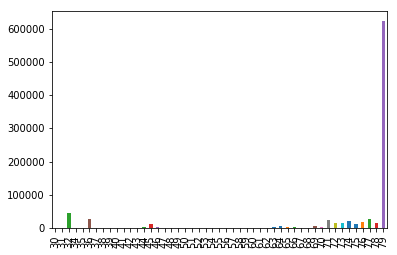

In [28]:
df1['full_count'].value_counts().sort_index().plot.bar()

- Here in investigating our visuallized column full_count we see trends of our data where the majority of our data has around 
has around 70 to 85 column populated with data. Here we identify that the rows outside of this range so less that 70 will be the lower end of our threshold and rows greater than 69 will be in our higher threshold dataset.
- Here we create dataframe df_lower with the lower end of our threshold. We also create df_higher to store the data for the upper end of our thershold

- Here we define a function that will review the column populated value for each row to determine if the row contains the optimal range for our data split.
- Here we define our optimal range as >= 9 and <= 32

In [30]:
def valid_col_count(row):
    if row['full_count'] >= 9 and row['full_count'] <= 32:
        rng = 'in_range'
    else:
        rng = 'not_in_range'
    return rng

In [31]:
df1['rng'] = df1.apply(lambda row: valid_col_count(row), axis=1)

In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
df_lower = df1.loc[(df1['rng'] == 'not_in_range')]
df_higher = df1.loc[(df1['rng'] == 'in_range')]

- Here we drop our range indicator column to avoid future issues with our datasets

In [33]:
df1.drop('rng', axis=1, inplace = True)
df_lower.drop('rng', axis=1, inplace = True)
df_higher.drop('rng', axis=1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


- Here we show the distrabution of our split datasets showing the total number of rows for the items not in our optimal range of 9 to 32 vs the population of data in our optimal range - here represented in df_higher

In [34]:
print('Population not in optimal range: ', len(df_lower), '| Population in optimal range: ', len(df_higher))

Population not in optimal range:  845640 | Population in optimal range:  45581


- Here we define a function that will create a bar chart to show the Population not in optimal range column distrubution from our data set df_lower which will be represented on the left bargraph alonside the Population in optimal range data set here df_higher. In this function we will send the column name, our df_lower and df_higher. Using seaborn's countplot function acompanied by matplotlib's subplot function to put the bar charts side by side. 
- Here in the function we add a try block to pharse out columns that may have invalid data for plotting

In [35]:
def show_plt(col, df2, df3):
    try:
        fig, ax =plt.subplots(1,2)
        sns.countplot(df2[col], ax=ax[0])
        sns.countplot(df3[col], ax=ax[1])
        plt.title("Column data distribution")
        fig.show()
    except:
        print('Could Not Plot Column: ', col)

In [36]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Could Not Plot Column:  HEALTH_TYP
Could Not Plot Column:  LP_LEBENSPHASE_FEIN
Could Not Plot Column:  LP_LEBENSPHASE_GROB
Could Not Plot Column:  LP_FAMILIE_FEIN
Could Not Plot Column:  LP_FAMILIE_GROB
Could Not Plot Column:  NATIONALITAET_KZ


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Could Not Plot Column:  SHOPPER_TYP
Could Not Plot Column:  VERS_TYP
Could Not Plot Column:  W_KEIT_KIND_HH
Could Not Plot Column:  ANZ_HAUSHALTE_AKTIV
Could Not Plot Column:  ANZ_HH_TITEL
Could Not Plot Column:  GEBAEUDETYP
Could Not Plot Column:  MIN_GEBAEUDEJAHR
Could Not Plot Column:  OST_WEST_KZ
Could Not Plot Column:  WOHNLAGE
Could Not Plot Column:  CAMEO_DEUG_2015
Could Not Plot Column:  CAMEO_DEU_2015
Could Not Plot Column:  CAMEO_INTL_2015
Could Not Plot Column:  KBA05_ANTG1
Could Not Plot Column:  KBA05_ANTG2
Could Not Plot Column:  KBA05_ANTG3
Could Not Plot Column:  KBA05_ANTG4
Could Not Plot Column:  KBA05_GBZ
Could Not Plot Column:  BALLRAUM
Could Not Plot Column:  EWDICHTE
Could Not Plot Column:  INNENSTADT
Could Not Plot Column:  GEBAEUDETYP_RASTER
Could Not Plot Column:  KKK
Could Not Plot Column:  MOBI_REGIO
Could Not Plot Column:  REGIOTYP
Could Not Plot Column:  KBA13_ANZAHL_PKW
Could Not Plot Column:  PLZ8_ANTG1
Could Not Plot Column:  PLZ8_ANTG2
Could Not Plot Co

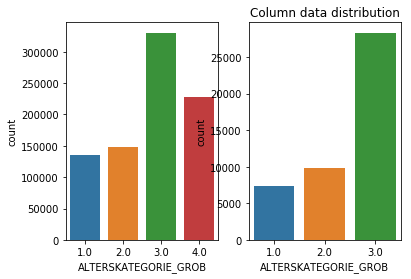

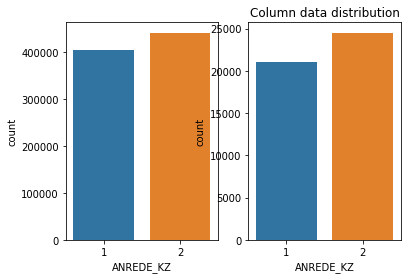

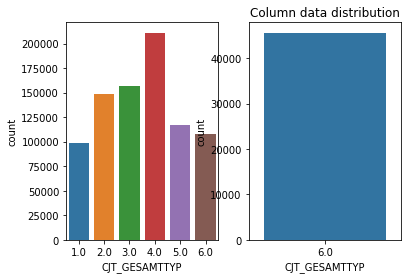

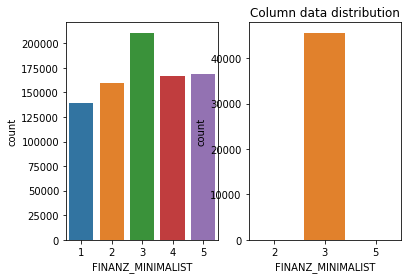

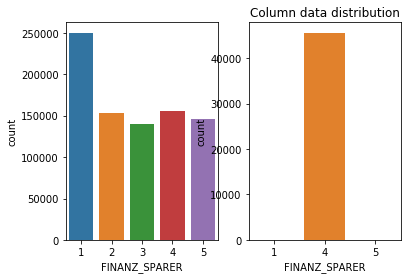

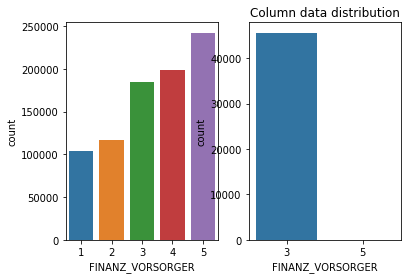

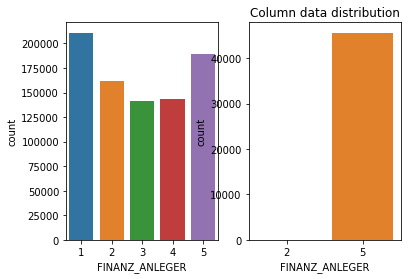

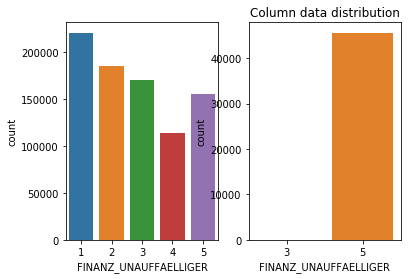

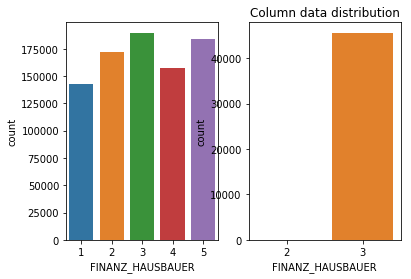

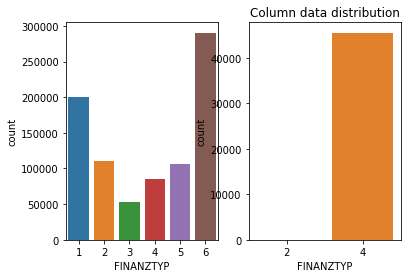

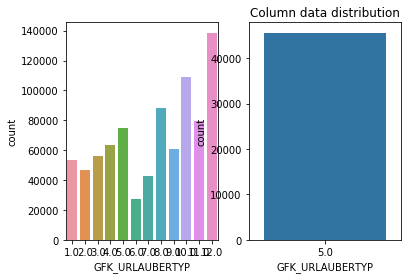

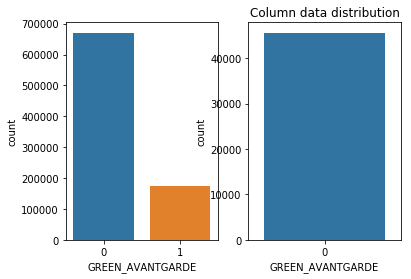

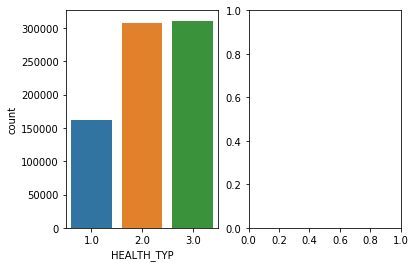

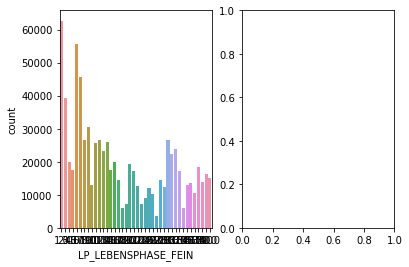

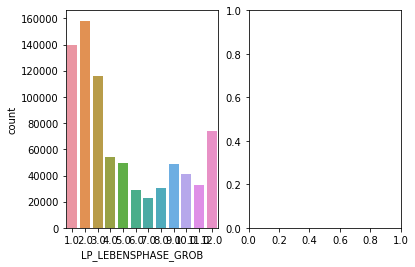

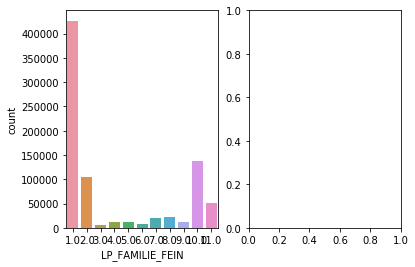

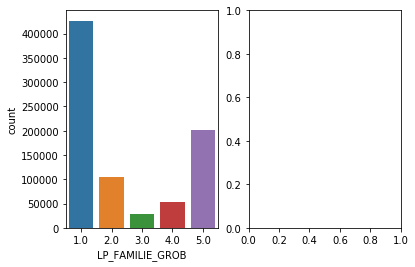

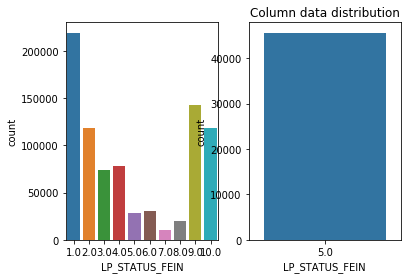

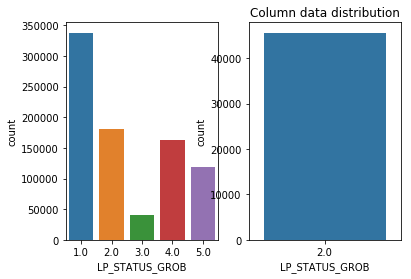

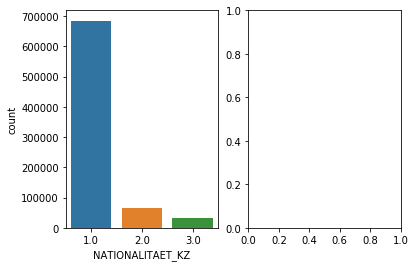

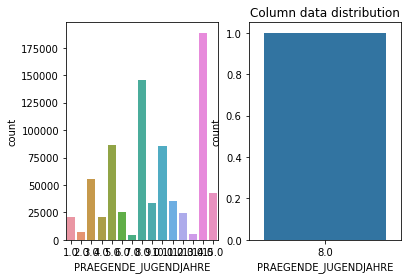

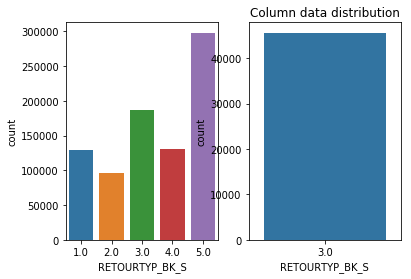

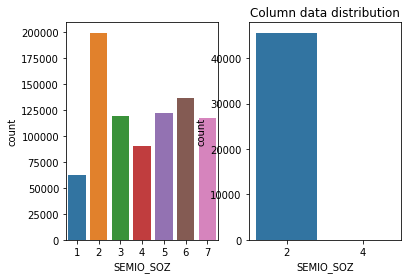

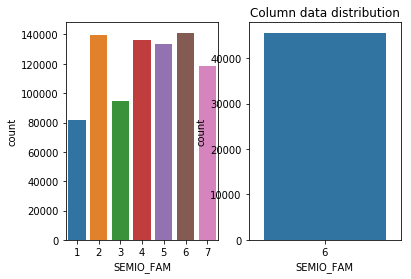

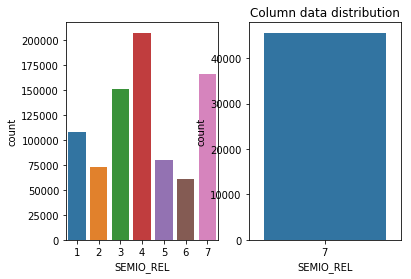

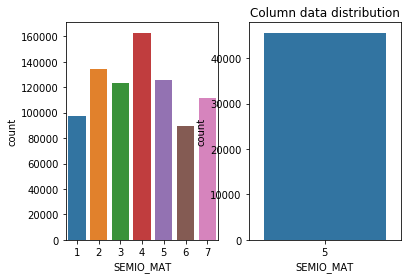

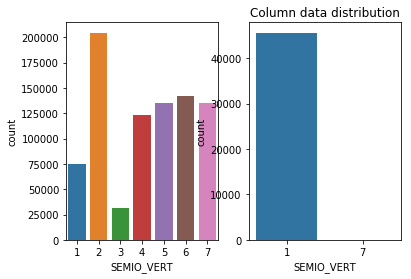

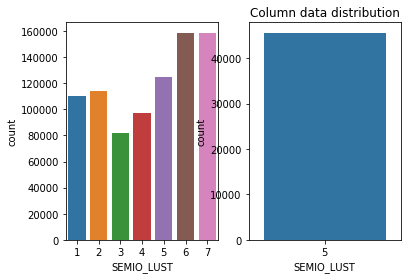

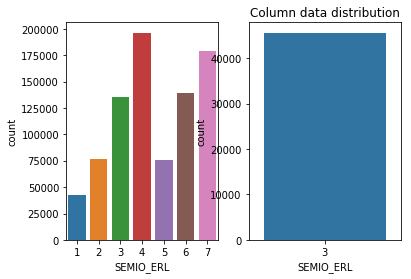

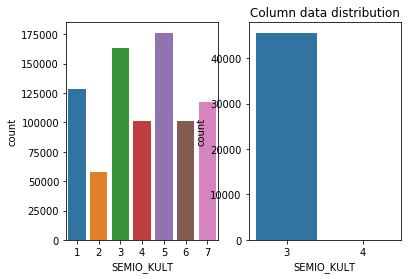

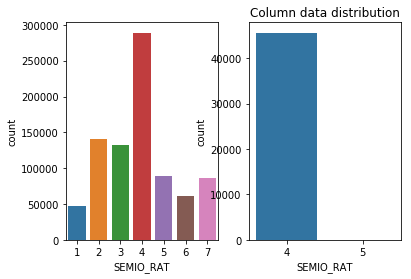

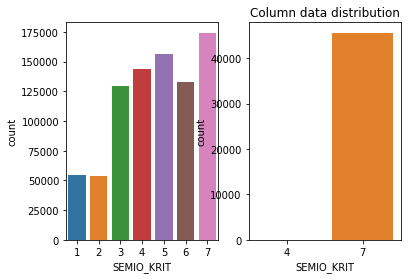

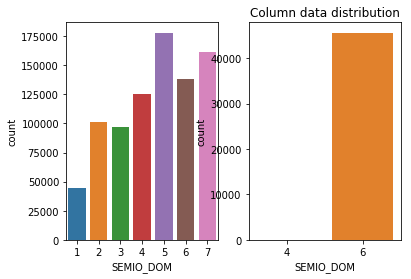

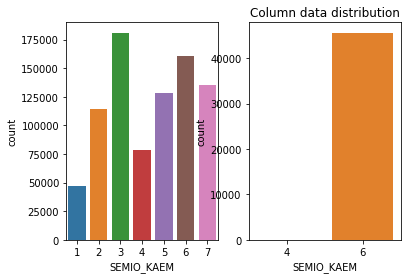

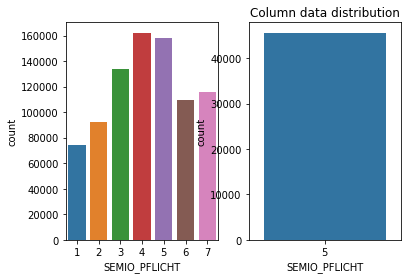

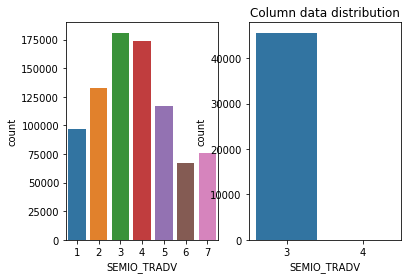

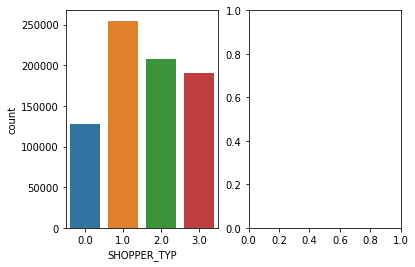

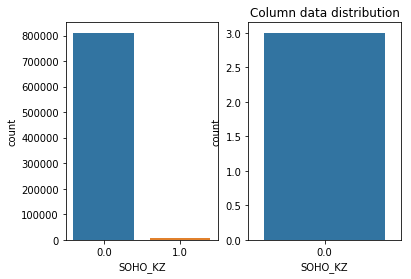

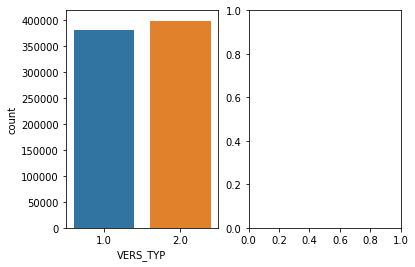

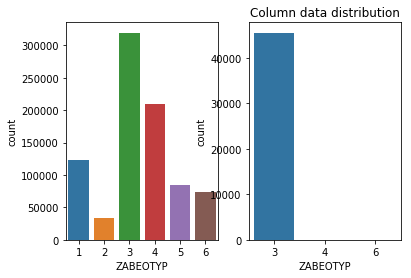

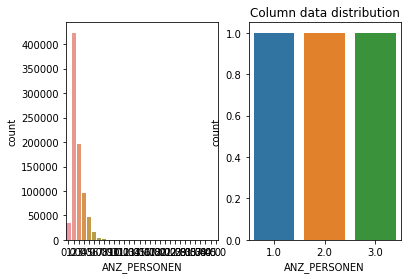

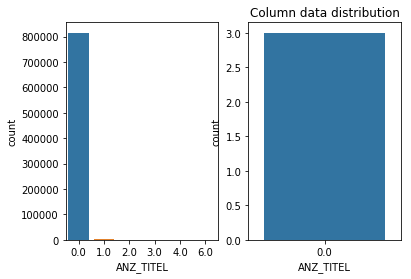

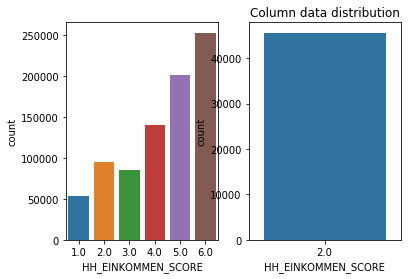

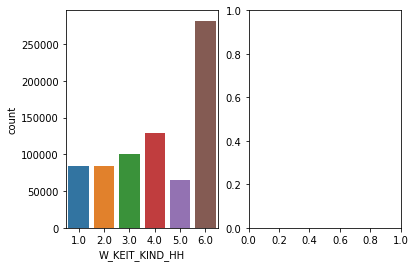

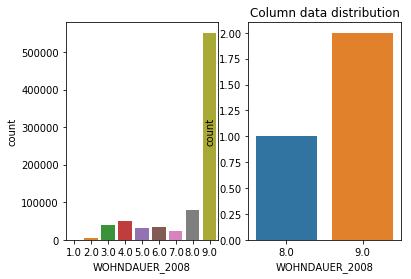

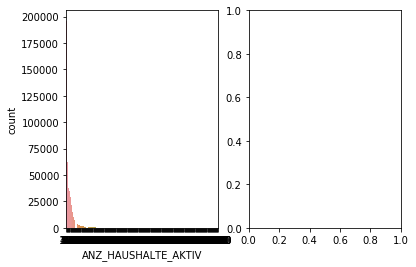

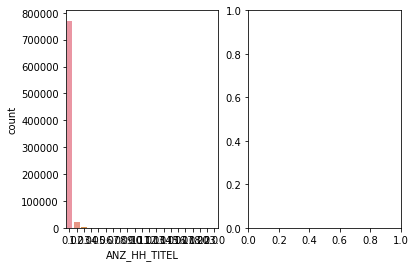

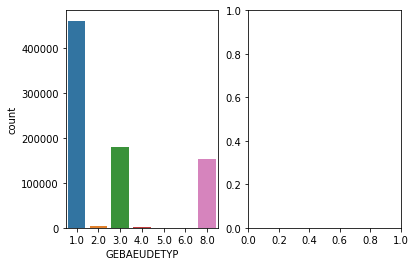

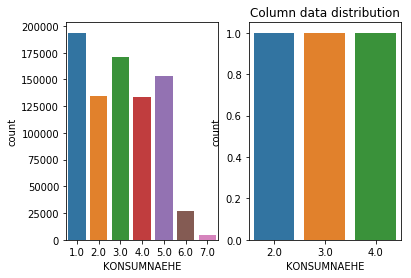

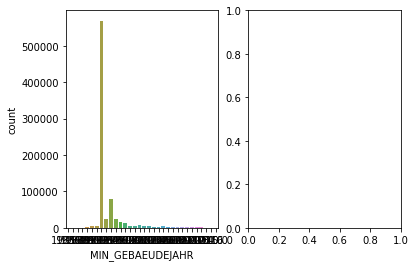

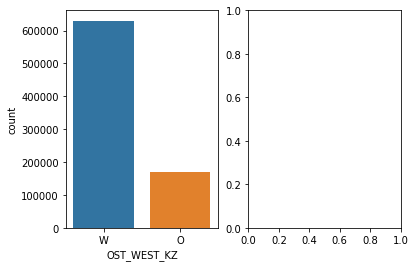

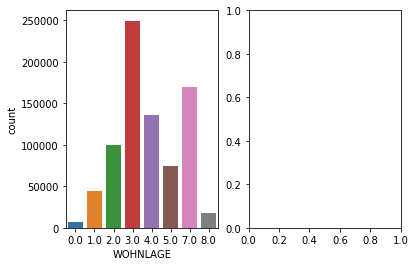

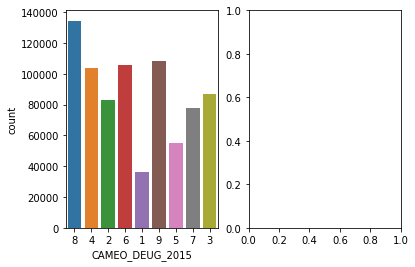

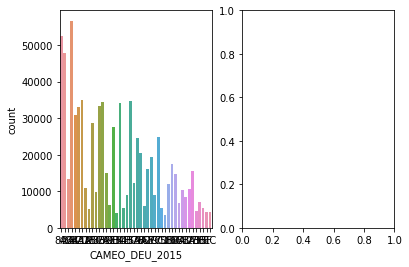

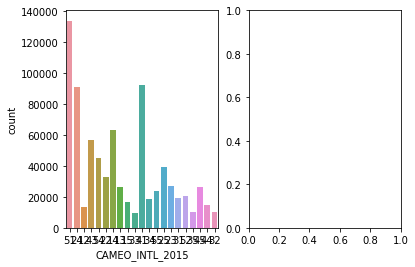

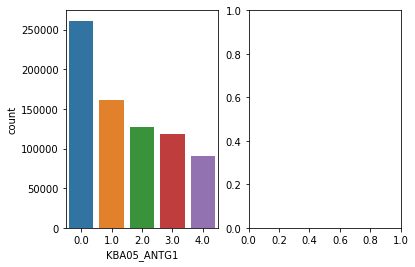

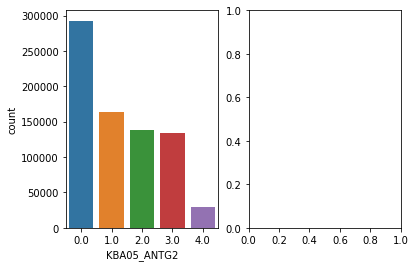

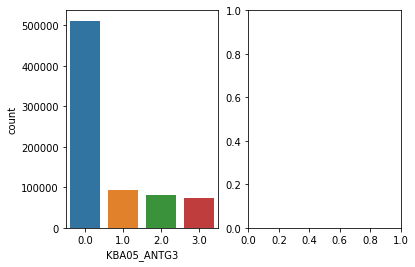

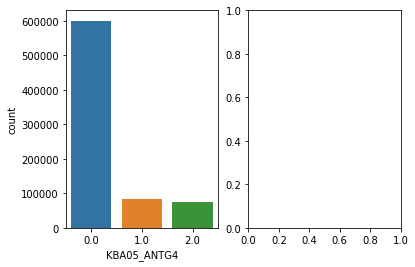

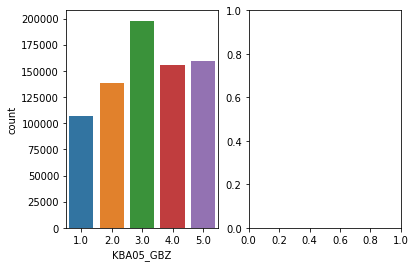

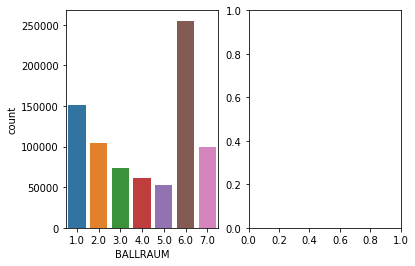

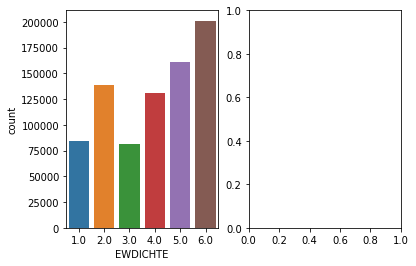

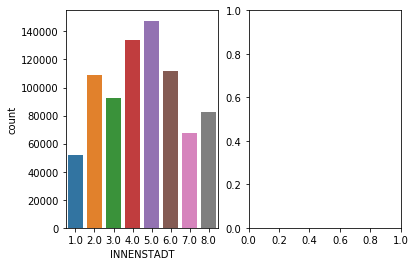

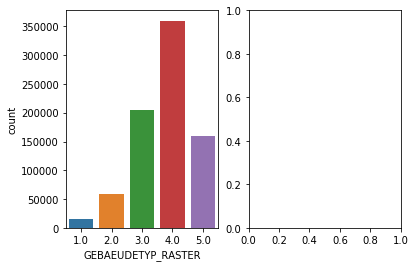

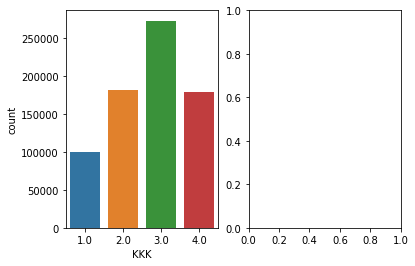

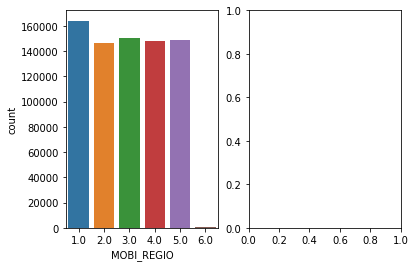

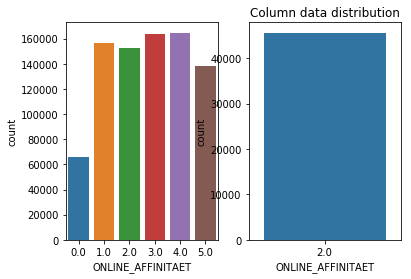

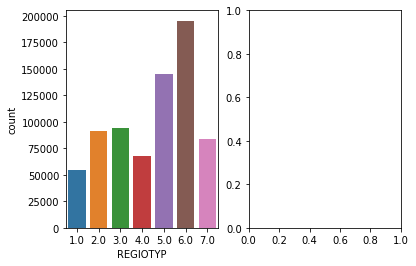

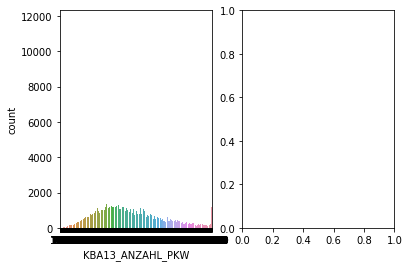

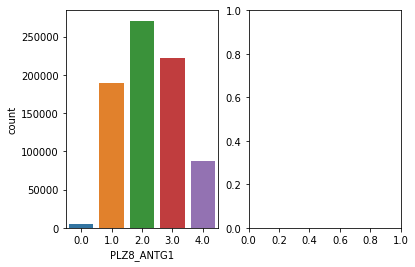

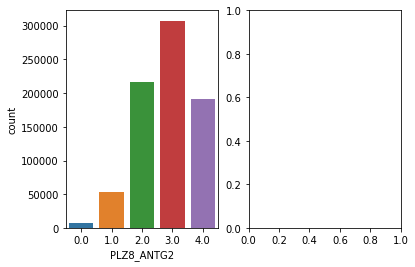

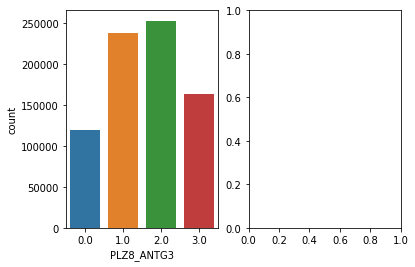

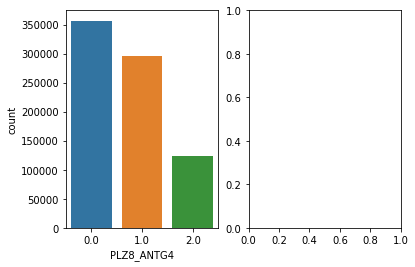

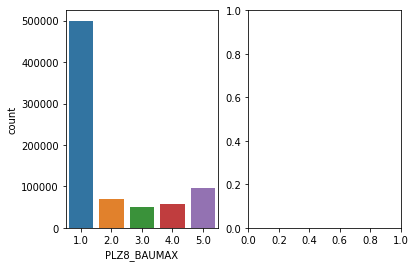

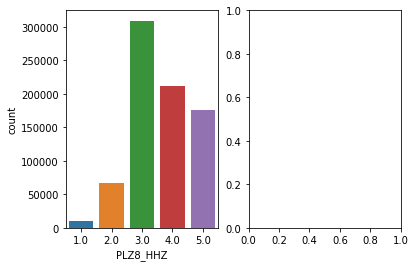

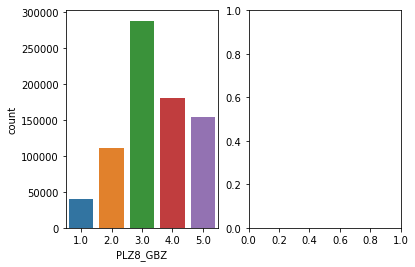

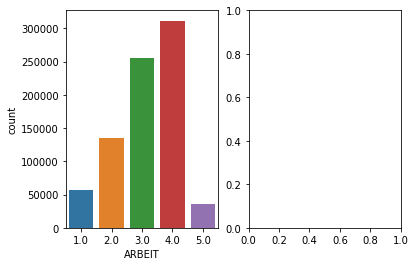

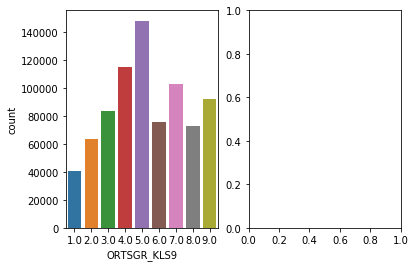

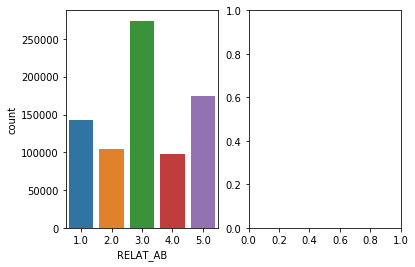

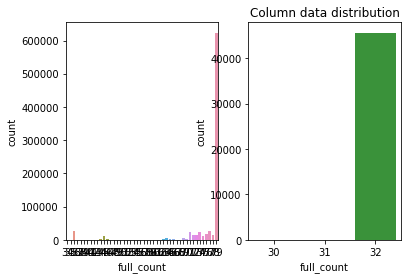

In [37]:
for col in df_lower.columns:
    show_plt(col, df_lower, df_higher)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- Here after visualizing our data from the lower threshold dataset side by side of our higher threshold. I've observed that is appears in the lower threshold dataset when values are being captured, they are heavily favored to one of the column values over the others. Here as some examples column CJT_GESAMTTYP we see the majority of the populated rows have a value of 6.0 where the higher threshold dataset has a more normalized distribution of data. We also see this pattern for column FINANZ_MINIMALIST where the majority of the values are populated with 3 in comparison to the higher threshold dataset has a more normalized distribution of data. This trend continues as follows column FINANZ_SPARER the majority of the data is populated with 4 in comparison to the higher threshold dataset our data is more evenly distributed. Next in column FINANZ_VORSORGER the majority of the data is populated with 3 in comparison to the higher threshold dataset the data here is left skewed. Looking into column FINANZ_UNAUFFAELLIGER we see the same trend in the lower threshold dataset our distribution of datapoint is overwhelmingly 5 whereas in our higher distribution our data is right skewed. For our last example of this we see that column FINANZ_HAUSBAUER in the lower threshold dataset is overwhelmingly populated with 3 and we have a more even distribution of our data in the higher threshold dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

- Here we explore the feature information dataset looking into the data types for the dataset.

In [38]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [39]:
for col in df_higher.columns:
    df_higher[col]

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

- Here we loop through our features information dataset. For each column we review if the columns data type is categorical or mixed we want to print the column details and values for analysis. Here we also include a criteria to verify the column has not been removed already in prior analysis.

In [41]:
for i in range(len(feat_info)): # for each row in dataframe
    col = feat_info['attribute'][i]
    if (feat_info['type'][i] == 'categorical' or feat_info['type'][i] == 'mixed') and col in df_higher.columns:
        print(feat_info['type'][i], feat_info['attribute'][i], df_higher[col].value_counts())

categorical ANREDE_KZ 2    24506
1    21075
Name: ANREDE_KZ, dtype: int64
categorical CJT_GESAMTTYP 6.0    45578
Name: CJT_GESAMTTYP, dtype: int64
categorical FINANZTYP 4    45580
2        1
Name: FINANZTYP, dtype: int64
categorical GFK_URLAUBERTYP 5.0    45578
Name: GFK_URLAUBERTYP, dtype: int64
categorical GREEN_AVANTGARDE 0    45581
Name: GREEN_AVANTGARDE, dtype: int64
mixed LP_LEBENSPHASE_FEIN Series([], Name: LP_LEBENSPHASE_FEIN, dtype: int64)
mixed LP_LEBENSPHASE_GROB Series([], Name: LP_LEBENSPHASE_GROB, dtype: int64)
categorical LP_FAMILIE_FEIN Series([], Name: LP_FAMILIE_FEIN, dtype: int64)
categorical LP_FAMILIE_GROB Series([], Name: LP_FAMILIE_GROB, dtype: int64)
categorical LP_STATUS_FEIN 5.0    45578
Name: LP_STATUS_FEIN, dtype: int64
categorical LP_STATUS_GROB 2.0    45578
Name: LP_STATUS_GROB, dtype: int64
categorical NATIONALITAET_KZ Series([], Name: NATIONALITAET_KZ, dtype: int64)
mixed PRAEGENDE_JUGENDJAHRE 8.0    1
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
categorica

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Here we replace the non-numeric values with 0 for items that contain W and 1 otherwise ( or if O)
df_higher["OST_WEST_KZ"] = np.where(df_higher["OST_WEST_KZ"] == "W", 0, 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


 - Here we verify our updates

In [43]:
df_higher["OST_WEST_KZ"].value_counts()

1    45581
Name: OST_WEST_KZ, dtype: int64

- Here we drop the column with multi-level categoricals CAMEO_DEU_2015

In [44]:
df_higher.drop('CAMEO_DEU_2015', axis=1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.1: Re-Encode Categorical Features

- Here after we explore all of the demographic informatin with a data type of categorical or mixed we can see that columns
(ANREDE_KZ, CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, GREEN_AVANTGARDE, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, SHOPPER_TYP, SOHO_KZ, VERS_TYP, ZABEOTYP, GEBAEUDETYP, OST_WEST_KZ, WOHNLAGE, CAMEO_DEUG_2015, CAMEO_INTL_2015, KBA05_BAUMAX, PLZ8_BAUMAX)     contain binary (two-level) categoricals that take numeric values, we will keep these without needing to do anything.
- There is one binary variable that takes on non-numeric values in column OST_WEST_KZ that contains values ( W and O). We will re-encode this as numbers 1 or 0 respectivley.
- One column that contains multi-level categoricals (three or more values) is CAMEO_DEU_2015 contains alpha numeric values such as (6B, 8A ect) we will drop column from our analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

- Here after reviewing the Data Dictionary and reviewing PRAEGENDE_JUGENDJAHRE the column values we see that the column's details outline we see that there is a category breakdown for each categorical values as described in section 1.18 (Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west).
- Here we create a function to assign the values for our new varibles then use the lamba function to call the function and return the specified value for each row in our dataset.
- Here we assign the decade year to an interval-type variable where the type is the decade integer value for example the 40's will be represented here as 40.
- For our second variable we will assign a binary value for Mainstream = 0 and Avantgarde = 1

In [45]:
df_higher['PRAEGENDE_JUGENDJAHRE'].value_counts()

8.0    1
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

- Here we create a function to assign the values for our new varibles
- Here we assign the decade year to an interval-type variable where the type is the decade integer value for example the 40's will be represented here as 40.
- For our second variable we will assign a binary value for Mainstream = 0 and Avantgarde = 1

In [46]:
def dec(row):
    if row['PRAEGENDE_JUGENDJAHRE'] != row['PRAEGENDE_JUGENDJAHRE']: #  check if the variable is equal to itself. If it is not, then it must be NaN value.
        decade = row['PRAEGENDE_JUGENDJAHRE']
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 1 or int(row['PRAEGENDE_JUGENDJAHRE']) == 2:
        decade = 40
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 3 or int(row['PRAEGENDE_JUGENDJAHRE']) == 4:
        decade = 50
    elif int(row['PRAEGENDE_JUGENDJAHRE']) >= 5 and int(row['PRAEGENDE_JUGENDJAHRE']) <= 7:
        decade = 60
    elif int(row['PRAEGENDE_JUGENDJAHRE']) >= 8 and int(row['PRAEGENDE_JUGENDJAHRE']) <= 9:
        decade = 70
    elif int(row['PRAEGENDE_JUGENDJAHRE']) >= 10 and int(row['PRAEGENDE_JUGENDJAHRE']) <= 13:
        decade = 80
    elif int(row['PRAEGENDE_JUGENDJAHRE']) >= 14 and int(row['PRAEGENDE_JUGENDJAHRE']) <= 15:
        decade = 90
    else:
        decade = row['PRAEGENDE_JUGENDJAHRE']
    return decade
def mov(row):
    if row['PRAEGENDE_JUGENDJAHRE'] != row['PRAEGENDE_JUGENDJAHRE']: #  check if the variable is equal to itself. If it is not, then it must be NaN value.
        mov = row['PRAEGENDE_JUGENDJAHRE']
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 1:
        mov = 0
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 2:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 3:
        mov = 0
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 4:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 5:
        mov = 0
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 6:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 7:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 8:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 9:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 10:
        mov = 0
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 11:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 12:
        mov = 0
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 13:
        mov = 1
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 14:
        mov = 0
    elif int(row['PRAEGENDE_JUGENDJAHRE']) == 15:
        mov = 1
    else:
        mov = row['PRAEGENDE_JUGENDJAHRE']
    return mov

In [47]:
df_higher['PRAEGENDE_JUGENDJAHRE_decade'] = df_higher.apply(lambda row: dec(row), axis=1)
df_higher['PRAEGENDE_JUGENDJAHRE_movement'] = df_higher.apply(lambda row: dec(row), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


- Here lets check our updates to our new column variables PRAEGENDE_JUGENDJAHRE_decade and PRAEGENDE_JUGENDJAHRE_movement

In [48]:
df_higher["PRAEGENDE_JUGENDJAHRE_decade"].value_counts()

70.0    1
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [49]:
df_higher["PRAEGENDE_JUGENDJAHRE_movement"].value_counts()

70.0    1
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64

- Here we explore column CAMEO_INTL_2015 reviewing the value count details
- We then create a function to assign the values for our new varibles then use the lamba function to call the function and return the specified value for each row in our dataset.
- Here we assign the tens column value to CAMEO_INTL_2015_t for our first new vairiable
- Then for our second variable we will the ones column value to CAMEO_INTL_2015_o for our second new variable

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_higher['CAMEO_INTL_2015'].value_counts()

Series([], Name: CAMEO_INTL_2015, dtype: int64)

- Here we create a function to assign the values for our new varibles
- Here we assign the tens columns to our new _t column. Where 50 would create 5 and 60 would create 6
- For our second variable we will assign the ones column _o. Where 99 would be 9 and 52 would be 2

In [51]:
def t(row):
    if row['CAMEO_INTL_2015'] != row['CAMEO_INTL_2015']: #  check if the variable is equal to itself. If it is not, then it must be NaN value.
        t = row['CAMEO_INTL_2015']
    else:
        t = str(row['CAMEO_INTL_2015'])[0]
    return t
def o(row):
    if row['CAMEO_INTL_2015'] != row['CAMEO_INTL_2015']: #  check if the variable is equal to itself. If it is not, then it must be NaN value.
        o = row['CAMEO_INTL_2015']
    else:
        o = str(row['CAMEO_INTL_2015'])[1]
    return o

In [52]:
df_higher['CAMEO_INTL_2015_t'] = df_higher.apply(lambda row: t(row), axis=1)
df_higher['CAMEO_INTL_2015_o'] = df_higher.apply(lambda row: o(row), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


- Here we test our updates

In [53]:
df_higher["CAMEO_INTL_2015_t"].value_counts()

Series([], Name: CAMEO_INTL_2015_t, dtype: int64)

In [54]:
df_higher["CAMEO_INTL_2015_o"].value_counts()

Series([], Name: CAMEO_INTL_2015_o, dtype: int64)

- Here after reviewing the data dictionary we determine we will be dropping columns LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE

In [55]:
df_higher.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace = True)
df_higher.drop('LP_LEBENSPHASE_GROB', axis=1, inplace = True)
df_higher.drop('WOHNLAGE', axis=1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.2: Engineer Mixed-Type Features

- After reviewing the Data Dictionary and reviewing PRAEGENDE_JUGENDJAHRE the column values we see that the column's details outline we see that there is a category breakdown for each categorical values as described in section 1.18 (Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west).
- We create a function to assign the values for our new varibles then use the lamba function to call the function and return the specified value for each row in our dataset.
- We we assign the decade year to an interval-type variable where the type is the decade integer value for example the 40's will be represented here as 40.
- For our second variable we will assign a binary value for Mainstream = 0 and Avantgarde = 1

- Then we explore column CAMEO_INTL_2015 reviewing the value count details
- We then create a function to assign the values for our new varibles then use the lamba function to call the function and return the specified value for each row in our dataset.
- Then we assign the tens column value to CAMEO_INTL_2015_t for our first new vairiable
- Then for our second variable we will the ones column value to CAMEO_INTL_2015_o for our second new variable

- In reviewing our dataset we also determine there are 5 other columns (LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE , KBA05_BAUMAX , PLZ8_BAUMAX ) that contain a mixed data type. 
- In reviewing the data dictionary we see that LP_LEBENSPHASE_FEIN contains information regarding Life stage, fine scale which has 40 unique values. We determine that we will not categorize this data and will drop this column
- In reviewing the data dictionary we see that LP_LEBENSPHASE_GROB contains information regarding Life stage, rough scale. Here the data shows life stage information alone with income data. Here the column values do not always contain both variables to be reviewed for example value 6 only shows single parents in comparision to column's with a value of 9 average earners of younger age from multiperson households. With the inconsistancy in these categories we decide to drop this column.
- In reviewing the data dictionary we see that column WOHNLAGE is either Neighborhood quality (or rural flag). Here we see that the values could show either value. We decide to drop this column.
- In reviewing KBA05_BAUMAX we see that this column is showing information about Most common building type within the microcell. Here we accept the groupings of the data which appear can be appropriate.
- Finally in reviewin PLZ8_BAUMAX we see the column is displaying data for Most common building type within the PLZ8 region. Simular to KBA05_BAUMAX we accept the groupings of the data which appear can be appropriate.




#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df_higher.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,full_count,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_t,CAMEO_INTL_2015_o
count,45581.000000,45581.000000,45578.0,45581.000000,45581.000000,45581.000000,45581.000000,45581.000000,45581.000000,45581.000000,...,0.0,0.0,0.0,0.0,0.0,45581.000000,1.0,1.0,0.0,0.0
mean,2.458151,1.537636,6.0,3.000022,3.999978,3.000044,4.999934,4.999956,2.999934,3.999956,...,NaN,NaN,NaN,NaN,NaN,31.999890,70.0,70.0,NaN,NaN
std,0.758040,0.498587,0.0,0.010474,0.015535,0.009368,0.014052,0.009368,0.008113,0.009368,...,NaN,NaN,NaN,NaN,NaN,0.014051,NaN,NaN,NaN,NaN
min,1.000000,1.000000,6.0,2.000000,1.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,30.000000,70.0,70.0,NaN,NaN
25%,2.000000,1.000000,6.0,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,32.000000,70.0,70.0,NaN,NaN
50%,3.000000,2.000000,6.0,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,32.000000,70.0,70.0,NaN,NaN
75%,3.000000,2.000000,6.0,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,32.000000,70.0,70.0,NaN,NaN
max,3.000000,2.000000,6.0,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,32.000000,70.0,70.0,NaN,NaN


- Here using the info function we verify our column type are all numeric, intercal and ordinal type columns.

In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
df_higher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45581 entries, 11 to 891187
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB              45581 non-null float64
ANREDE_KZ                         45581 non-null int64
CJT_GESAMTTYP                     45578 non-null float64
FINANZ_MINIMALIST                 45581 non-null int64
FINANZ_SPARER                     45581 non-null int64
FINANZ_VORSORGER                  45581 non-null int64
FINANZ_ANLEGER                    45581 non-null int64
FINANZ_UNAUFFAELLIGER             45581 non-null int64
FINANZ_HAUSBAUER                  45581 non-null int64
FINANZTYP                         45581 non-null int64
GFK_URLAUBERTYP                   45578 non-null float64
GREEN_AVANTGARDE                  45581 non-null int64
HEALTH_TYP                        0 non-null float64
LP_FAMILIE_FEIN                   0 non-null float64
LP_FAMILIE_GROB                   0 non-null float64
LP_STATUS_FEIN                    45578 non-null float64
LP_STAT

- After reviewing our dataset we determine our two new column variables need to be updated to a numeric value. We complete that here.

In [58]:
# convert just columns "CAMEO_INTL_2015_t" and "CAMEO_INTL_2015_o"
df_higher[["CAMEO_INTL_2015_t", "CAMEO_INTL_2015_o"]] = df_higher[["CAMEO_INTL_2015_t", "CAMEO_INTL_2015_o"]].apply(pd.to_numeric)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


- Here we drop the original mixed column details that we used to create new binary, interval and ordinal types from above for columns (CAMEO_INTL_2015, PRAEGENDE_JUGENDJAHRE)

In [59]:
df_higher.drop('CAMEO_INTL_2015', axis=1, inplace = True)
df_higher.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

- Here we take a look at the CUSTOMERS_Subset reviewing the column details. Here we can see the columns match our population demographics 

In [60]:
x = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ";") # import (Summary of feature attributes for demographics data) dataset using a semicolon separator
x.head(1)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0


## Update clean function to include updates made.
- Adjusted threshold for missing columns to 20% here we dropped columns: AGER_TYP, GEBURTSJAHR TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX.
- Updated the threshold for our dataset from 9 to 32
- removed new column rng from all datasets
- send clean manual column names so we insure we remove these columns from the clean function

In [62]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx, row in feat_info.iterrows():
        missing_or_unknown = row['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[]') # remove [ ] from string
        missing_or_unknown = missing_or_unknown.split(',') # split values with , sep  
        missing_or_unknown = [int(value) if value not in {'X', 'XX', ''} else value # Convert each value to int if it's not 'X', 'XX', or an empty string
                              for value in missing_or_unknown]
        if missing_or_unknown:     # If the list is not empty, replace the corresponding values in azdias with NaN
            attr_name = row['attribute']
            df = df.replace({attr_name: missing_or_unknown}, np.nan)
    
    # remove selected columns and rows, ...
    a_list = []
    b_list = []
    for col in azdias.columns:
        null_rows = azdias[col].isna().sum()
        null_rate = round(null_rows / len(azdias) * 100)
        if null_rate > 0:
            a_list.append(col)
            b_list.append(null_rate)
    df1 = pd.DataFrame({'Column_Name': a_list, 'Null_Rate': b_list})    
    del a_list, b_list
    
    for i in range(len(df1)): # for each row in our missing column rates dataframe if the rate is > 20 lets drop the column
        a = df1['Column_Name'][i]
        if df1['Null_Rate'][i] > 20:
            #print('Dropped Column:', a)
            df.drop(a, axis=1, inplace = True)
            
    df['full_count'] = df.apply(lambda x: x.count(), axis=1) # create a column for each row to identify missing values per row
    
    df['rng'] = df.apply(lambda row: valid_col_count(row), axis=1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    df_h = df.loc[(df['rng'] == 'in_range')]
    df.drop('rng', axis=1, inplace = True)  
    df_h.drop('rng', axis=1, inplace = True)  
       
    # select, re-encode, and engineer column values.
    df_h["OST_WEST_KZ"] = np.where(df_h["OST_WEST_KZ"] == "W", 0, 1)
    df_h.drop('CAMEO_DEU_2015', axis=1, inplace = True)
    df_h['PRAEGENDE_JUGENDJAHRE_decade'] = df_h.apply(lambda row: dec(row), axis=1)
    df_h['PRAEGENDE_JUGENDJAHRE_movement'] = df_h.apply(lambda row: dec(row), axis=1)
    df_h['CAMEO_INTL_2015_t'] = df_h.apply(lambda row: t(row), axis=1)
    df_h['CAMEO_INTL_2015_o'] = df_h.apply(lambda row: o(row), axis=1)
    df_h.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace = True)
    df_h.drop('LP_LEBENSPHASE_GROB', axis=1, inplace = True)
    df_h.drop('WOHNLAGE', axis=1, inplace = True)
    df_h[["CAMEO_INTL_2015_t", "CAMEO_INTL_2015_o"]] = df_h[["CAMEO_INTL_2015_t", "CAMEO_INTL_2015_o"]].apply(pd.to_numeric)
    df_h.drop('CAMEO_INTL_2015', axis=1, inplace = True)
    df_h.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace = True)
    
    # Return the cleaned dataframe.
    return df_h    

- Here lets test our clean function on our original dataset and insure we get the same results as our manual dataset.

In [63]:
df2 = azdias.copy() # Create a copy of the original dataset
azdias_clean_data = clean_data(df2)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-p

In [64]:
assert azdias_clean_data.shape[0] == df_higher.shape[0], "clean_data function is not working properly, rows mismatch"
assert azdias_clean_data.shape[1] == df_higher.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


- Here is our original clean function

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import scipy.sparse as sp

- Here we use the Imputuer function from sklearn to transformer completing missing values. Here we selected the “mean”, then replace missing values using the mean along the axis for the strategy.
- Next we created a new dataframe that replaced all of the values in our dataset

### Fix me.. Having issues with imputer removing columns

In [113]:
#df_higher.replace(np.nan, 0)

In [114]:
imp = Imputer(missing_values=np.nan, strategy='mean', axis = 0)
imp.fit(df_higher)
df_higher_imp = imp.transform(df_higher)

In [115]:
df_higher_imp = pd.DataFrame(df_higher_imp, columns = df_higher.columns)

ValueError: Shape of passed values is (41, 45581), indices imply (78, 45581)

In [110]:
df_higher_imp = pd.DataFrame(imp.transform(df_higher), columns = df_higher.columns)

ValueError: Shape of passed values is (41, 45581), indices imply (78, 45581)

In [ ]:
df_higher_imp_x = 

In [103]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer(missing_values=np.nan, strategy='mean')
df_higher_imp = pd.DataFrame(imp.fit_transform(df_higher))

In [104]:
df_higher_imp.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
1,3.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
2,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
3,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
4,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0


In [76]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [84]:
len(df_higher)
len(df_higher.columns)

78

In [100]:
# here these imputers are dropping columns
#imp = Imputer(missing_values=np.nan, strategy='mean') # here we create our imputer strategy.
#imp = Imputer(missing_values=float('nan'), strategy='mean') # here we create our imputer strategy.
imp = Imputer(strategy='mean') # here we create our imputer strategy.

In [101]:
df_higher_imp = pd.DataFrame(imp.fit_transform(df_higher)) # here for our dataset we apply our imputer strategy for NaN values

In [102]:
df_higher_imp.head(5) # here we take a look at our dataset after our updates

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
1,3.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
2,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
3,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0
4,3.0,2.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,0.0,2.0,8.666667,3.0,1.0,2.0,32.0,70.0,70.0


In [99]:
#here we need to assign the column names to our dataframe after applying our imputer
df_higher_imp.columns = df_higher.columns

ValueError: Length mismatch: Expected axis has 41 elements, new values have 78 elements

In [88]:
imp.fit(df_higher) # here lets update our dataset with our Imputer strategy to replace the NaN values with mean
df_higher_imp = imp.transform(df_higher) # here lets update our dataset with our Imputer strategy to replace the NaN values with mean

- Here we explore our transformed data after we have assigned our Imputer strategy to our dataset

In [75]:
df_higher_imp

array([[  2.,   1.,   6., ...,  32.,  70.,  70.],
       [  3.,   1.,   6., ...,  32.,  70.,  70.],
       [  2.,   1.,   6., ...,  32.,  70.,  70.],
       ..., 
       [  3.,   2.,   6., ...,  32.,  70.,  70.],
       [  3.,   1.,   6., ...,  32.,  70.,  70.],
       [  3.,   2.,   6., ...,  32.,  70.,  70.]])

- Here we apply the actual scaling function, a StandardScaler instance is suggested, scaling each feature to mean 0 and standard deviation 1.

In [81]:
scaler = StandardScaler()
df_higher_imp_scaled = scaler.fit_transform(df_higher_imp)

- Here we see that we need to apply our column names from our original dataset

In [82]:
df_scaled = pd.DataFrame(df_higher_imp_scaled, columns = df_higher.columns)

ValueError: Shape of passed values is (41, 45581), indices imply (78, 45581)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- We use the Imputuer function from sklearn to transformer completing missing values. Here we selected the “mean”, then replace missing values using the mean along the axis for the strategy.
- We then apply a standard scaler and on the scaler we use the fit_transform function.
- Then we created a new dataframe that replaced all of the values in our dataset

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

- Here we aplpy PCA to our dataset. Reference PCA steps from Stack Overflow: https://stackoverflow.com/questions/23282130/principal-components-analysis-using-pandas-dataframe

In [64]:
# Apply PCA to the data.

# You must normalize the data before applying the fit method
df_normalized=(df_higher_imp - df_higher_imp.mean()) / df_higher_imp.std()
pca = PCA(n_components=df_higher_imp.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

                                     PC0       PC1       PC2       PC3  \
ALTERSKATEGORIE_GROB           -0.099552  0.233100  0.023975  0.009164   
ANREDE_KZ                       0.011271  0.043585 -0.368158  0.017411   
CJT_GESAMTTYP                   0.043931 -0.116810 -0.018688  0.079217   
FINANZ_MINIMALIST              -0.200047  0.077412  0.135380  0.087538   
FINANZ_SPARER                   0.129407 -0.225735 -0.061328 -0.025730   
FINANZ_VORSORGER               -0.099486  0.220661  0.055878 -0.002733   
FINANZ_ANLEGER                  0.063324 -0.202784 -0.144215 -0.097353   
FINANZ_UNAUFFAELLIGER           0.065885 -0.218258 -0.063827  0.004607   
FINANZ_HAUSBAUER                0.148797  0.102490 -0.055544 -0.106918   
FINANZTYP                      -0.058234  0.107103  0.098694  0.053139   
GEBURTSJAHR                     0.074992 -0.201742 -0.054331  0.026145   
GFK_URLAUBERTYP                 0.060721 -0.032471 -0.014480 -0.048638   
GREEN_AVANTGARDE               -0.0999

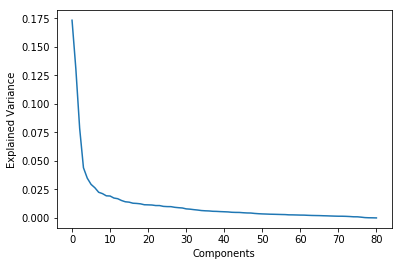

In [65]:
# Investigate the variance accounted for by each principal component.
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [66]:
def simulate_data(n = 500, features = 10, centroids = 3):
    '''
    Simulates n data points, each with number of features equal to features, with a number of centers equal to centroids
    INPUT (defaults)
        n = number of rows (500)
        features = number of columns (10)
        centroids = number of centers (3)
    Output
        dataset = a dataset with the the specified characteristics
    '''
    dataset, y = make_blobs(n_samples=n, n_features=features, centers=centroids, random_state=42)

    return dataset

In [67]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

    data = simulate_data(200, 5, 4)

- Here in visualizing the explained varianec we can see the clear elbow here at around 10. Next we will re-apply PCA with

In [68]:
df_normalized=(df_higher_imp - df_higher_imp.mean()) / df_higher_imp.std()
pca = PCA(n_components=10)
pca.fit(df_normalized)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.2: Perform Dimensionality Reduction

- Here we transformed our data using PCA to initally on the entire dataset. After running the variance explaination fofr all of the components we could see the elbow here at around 10. Next we ran the PCA on 10 componets. Taking our  full dataset and reducing it to only the parts that hold the most information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

- Here we define a funtion we can call to print the prinicpal compontens. Printing the dataframe in decending order by the first principal component.
- Here in this function we send the pca information along with the column we would like to print. Here we can recall this any PC column that exists.

In [70]:
def print_fpc(pca, col):
    # Reformat and view results
    loadings = pd.DataFrame(pca.components_.T,
    columns=['PC%s' % _ for _ in range(10)],
    index=df_normalized.columns)
    print(loadings[col].sort_values(ascending=False))

- Here we call our print function for our first prinicple component.

In [71]:
print_fpc(pca, 'PC0')

PLZ8_ANTG3                        0.194121
CAMEO_DEUG_2015                   0.189796
PLZ8_ANTG4                        0.189606
CAMEO_INTL_2015_t                 0.186319
PLZ8_BAUMAX                       0.185872
HH_EINKOMMEN_SCORE                0.185682
KBA05_BAUMAX                      0.175750
ORTSGR_KLS9                       0.165211
EWDICHTE                          0.163483
FINANZ_HAUSBAUER                  0.148797
KBA05_ANTG4                       0.135370
PLZ8_ANTG2                        0.131630
FINANZ_SPARER                     0.129407
ZABEOTYP                          0.127646
ANZ_HAUSHALTE_AKTIV               0.119356
KBA05_ANTG3                       0.119128
ARBEIT                            0.119051
RELAT_AB                          0.112637
SEMIO_PFLICHT                     0.095627
SEMIO_REL                         0.091827
PRAEGENDE_JUGENDJAHRE_decade      0.091133
PRAEGENDE_JUGENDJAHRE_movement    0.091133
SEMIO_RAT                         0.079741
GEBURTSJAHR

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

- Here we call our print function for our second prinicple component.

In [73]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_fpc(pca, 'PC1')

ALTERSKATEGORIE_GROB              0.233099
FINANZ_VORSORGER                  0.220661
SEMIO_ERL                         0.182915
SEMIO_LUST                        0.164043
RETOURTYP_BK_S                    0.160156
W_KEIT_KIND_HH                    0.129324
FINANZTYP                         0.107103
FINANZ_HAUSBAUER                  0.102490
PLZ8_ANTG3                        0.081626
SHOPPER_TYP                       0.081448
PLZ8_ANTG4                        0.078649
FINANZ_MINIMALIST                 0.077412
SEMIO_KRIT                        0.077364
EWDICHTE                          0.075504
PLZ8_BAUMAX                       0.074858
ORTSGR_KLS9                       0.074743
CAMEO_INTL_2015_t                 0.069274
KBA05_BAUMAX                      0.066303
CAMEO_DEUG_2015                   0.064974
SEMIO_KAEM                        0.063654
KBA05_ANTG4                       0.061681
ARBEIT                            0.058715
ANZ_HAUSHALTE_AKTIV               0.055980
PLZ8_ANTG2 

- Here we call our print function for our third prinicple component.

In [74]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_fpc(pca, 'PC2')

SEMIO_VERT                        0.339264
SEMIO_FAM                         0.275223
SEMIO_SOZ                         0.269234
SEMIO_KULT                        0.267093
FINANZ_MINIMALIST                 0.135379
SEMIO_REL                         0.118746
FINANZTYP                         0.098688
SEMIO_MAT                         0.086317
RETOURTYP_BK_S                    0.078406
W_KEIT_KIND_HH                    0.074886
FINANZ_VORSORGER                  0.055877
PLZ8_BAUMAX                       0.040676
PLZ8_ANTG4                        0.036584
GREEN_AVANTGARDE                  0.035259
PLZ8_ANTG3                        0.034576
LP_STATUS_GROB                    0.033675
ORTSGR_KLS9                       0.031824
EWDICHTE                          0.030062
ARBEIT                            0.027919
CAMEO_DEUG_2015                   0.025447
CAMEO_INTL_2015_t                 0.024623
ALTERSKATEGORIE_GROB              0.023971
KBA05_BAUMAX                      0.023886
SEMIO_LUST 

### Discussion 2.3: Interpret Principal Components

- Here when we have our reducted dataset which uses 10 of our prinicle componets looking into the print the linked values, sorted by weight for the first 3 prinicle componets we can see ranges in the weights for each of the first three principle components.
- Here when looking at the first component we see our highest weight for column PLZ8_ANTG3 with a value of 0.194121, in comparision to the minimun weight here for column MOBI_REGIO which came in at -0.213796. 
- Next in looking at our second component we can see our hiest weight came in for column ALTERSKATEGORIE_GROB with a value of 0.233100 in comparision to our lowest weighted column which is PRAEGENDE_JUGENDJAHRE_movement with a weight of -0.248824.
- Finally we look at our third component we see our the highest weight for column SEMIO_VERT 0.339260 were as our lowest weighted column was ANREDE_KZ with a value of -0.368153.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [76]:
kmeans = KMeans(n_clusters=10)
model = kmeans.fit(df_normalized)
score = model.score(df_normalized)

In [77]:
# A place for your work - create a scree plot - you will need to
# Fit a kmeans model with changing k from 1-10
# Obtain the score for each model (take the absolute value)
# Plot the score against k

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [78]:
scores = []
centers = list(range(1,12))

for center in centers:
    scores.append(get_kmeans_score(df_normalized, center))

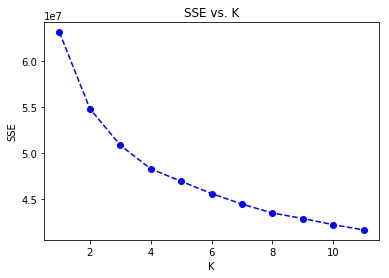

In [79]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [80]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [81]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


In [82]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Try instantiating a model with 8 centers
kmeans_8 = KMeans(n_clusters=8)

# Then fit the model to your data using the fit method
model_8 = kmeans_8.fit(df_normalized)

# Finally predict the labels on the same data to show the category that point belongs to
labels_8 = model_8.predict(df_normalized) #ta using the fit method

### Discussion 3.1: Apply Clustering to General Population

Here when we apply the Kmeans to our dataset on 11 clusters we see that the elbow in this data is right at 4. Here we see at the 8 mark the data really levels off level off. Here we visualize our 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [83]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ";") # import (Summary of feature attributes for demographics data) dataset using a semicolon separator

In [84]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-p

In [85]:
imp1 = Imputer(missing_values=np.nan, strategy='mean')

In [86]:
customers_clean.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,full_count,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_t,CAMEO_INTL_2015_o
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,5.0,5.0,1.0,2.0,1.0,81,50.0,50.0,1.0,3.0
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,3.0,2.0,3.0,5.0,3.0,80,50.0,50.0,3.0,4.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,4.0,1.0,3.0,1.0,75,40.0,40.0,2.0,4.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,3.0,3.0,3.0,5.0,1.0,82,70.0,70.0,4.0,1.0
5,1.0,3.0,1,4.0,5,1,5,1,2,3,...,5.0,5.0,3.0,7.0,5.0,81,50.0,50.0,3.0,4.0


In [87]:
customers_imp = pd.DataFrame(imp1.fit_transform(customers_clean))

In [88]:
customers_imp.head(5)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,2.00000,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,...,5.0,5.0,1.0,2.0,1.0,81.0,50.0,50.0,1.0,3.0
1,1.65013,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,...,3.0,2.0,3.0,5.0,3.0,80.0,50.0,50.0,3.0,4.0
2,1.00000,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,...,3.0,4.0,1.0,3.0,1.0,75.0,40.0,40.0,2.0,4.0
3,1.65013,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,...,3.0,3.0,3.0,5.0,1.0,82.0,70.0,70.0,4.0,1.0
4,1.00000,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,3.0,...,5.0,5.0,3.0,7.0,5.0,81.0,50.0,50.0,3.0,4.0


In [89]:
customers_imp.columns = customers_clean.columns

In [90]:
# Apply PCA to the data.

# You must normalize the data before applying the fit method
customers_normalized=(customers_imp - customers_imp.mean()) / customers_imp.std()
pca3 = PCA(n_components=customers_normalized.shape[1])
pca3.fit(customers_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca3.components_.T,
columns=['PC%s' % _ for _ in range(len(customers_normalized.columns))],
index=customers_normalized.columns)
print(loadings)

                                     PC0       PC1       PC2       PC3  \
AGER_TYP                        0.039652  0.041398 -0.013166  0.003221   
ALTERSKATEGORIE_GROB           -0.007710 -0.239634 -0.037799 -0.012134   
ANREDE_KZ                       0.105792  0.031970 -0.322944  0.113375   
CJT_GESAMTTYP                  -0.009105  0.129676  0.047453  0.093617   
FINANZ_MINIMALIST              -0.211220 -0.110901  0.055276  0.065780   
FINANZ_SPARER                   0.020280  0.287876  0.002755 -0.022615   
FINANZ_VORSORGER               -0.004940 -0.281953 -0.001568  0.003190   
FINANZ_ANLEGER                 -0.003987  0.246759 -0.117087 -0.091644   
FINANZ_UNAUFFAELLIGER          -0.021913  0.197943 -0.000247  0.026311   
FINANZ_HAUSBAUER                0.203316 -0.089723 -0.032085 -0.056610   
FINANZTYP                       0.019815  0.006637  0.092255  0.053405   
GEBURTSJAHR                    -0.019182  0.275180 -0.006327  0.017918   
GFK_URLAUBERTYP                 0.0184

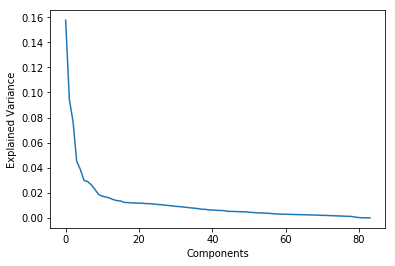

In [91]:
# Investigate the variance accounted for by each principal component.
plt.plot(pca3.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Try instantiating a model with 8 centers
kmeans_10 = KMeans(n_clusters=10)

# Then fit the model to your data using the fit method
model_10 = kmeans_10.fit(customers_normalized)

# Finally predict the labels on the same data to show the category that point belongs to
labels_10 = model_10.predict(customers_normalized) #ta using the fit method

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


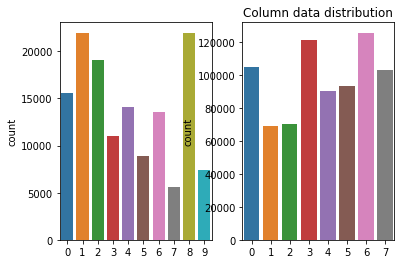

In [93]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
#def show_plt(col, df2, df3):
try:
    fig, ax =plt.subplots(1,2)
    sns.countplot(labels_10, ax=ax[0])
    sns.countplot(labels_8, ax=ax[1])
    plt.title("Column data distribution")
    fig.show()
except:
    print('Could Not Plot Column: ', col)

In [94]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
X_pca = pca.fit_transform(df_normalized)

In [95]:
def simulate_data(n = 500, features = 10, centroids = 3):
    '''
    Simulates n data points, each with number of features equal to features, with a number of centers equal to centroids
    INPUT (defaults)
        n = number of rows (500)
        features = number of columns (10)
        centroids = number of centers (3)
    Output
        dataset = a dataset with the the specified characteristics
    '''
    dataset, y = make_blobs(n_samples=n, n_features=features, centers=centroids, random_state=42)

    return dataset

In [96]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

data = simulate_data(200, 5, 4)

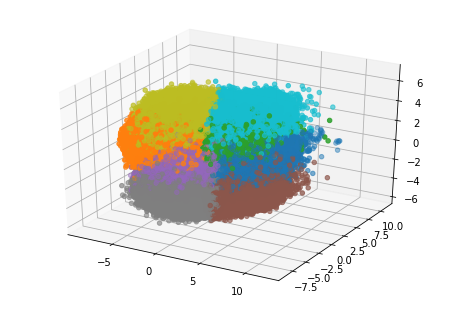

In [97]:
plot_data(X_pca, labels_8)

In [98]:
Y_pca = pca3.fit_transform(customers_normalized)

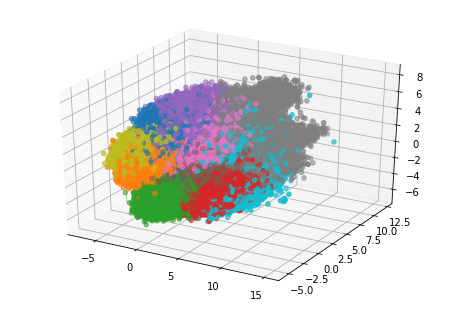

In [99]:
plot_data(Y_pca, labels_10)

In [100]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [101]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [102]:
pca, X_pca = do_pca(8, df_normalized)

In [103]:
df_normalized.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,full_count,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_t,CAMEO_INTL_2015_o
count,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,...,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05,7.800390e+05
mean,8.108591e-14,-6.061629e-17,1.151565e-13,-1.025590e-16,1.459660e-16,1.186000e-17,-3.486040e-17,1.538339e-16,-7.881165e-17,-7.194341e-17,...,2.952579e-13,9.757895e-14,4.404919e-14,1.039782e-13,-6.507541e-14,2.001991e-15,-2.212037e-12,-2.212037e-12,1.124826e-14,-9.497052e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.766327e+00,-1.043331e+00,-1.629028e+00,-1.489252e+00,-1.150742e+00,-1.771568e+00,-1.247551e+00,-1.172306e+00,-1.531762e+00,-1.348650e+00,...,-2.697754e+00,-2.152554e+00,-2.186251e+00,-1.875115e+00,-1.533155e+00,-3.912394e+00,-2.317830e+00,-2.317830e+00,-1.555271e+00,-1.260552e+00
25%,-7.836438e-01,-1.043331e+00,-9.767171e-01,-7.634435e-01,-1.150742e+00,-1.045319e+00,-1.247551e+00,-1.172306e+00,-8.169209e-01,-8.700808e-01,...,-6.327591e-01,-3.438749e-01,-1.748820e-01,-5.687447e-01,-7.955974e-01,-3.556136e-01,-9.231615e-01,-9.231615e-01,-8.712972e-01,-1.260552e+00
50%,1.990395e-01,9.584670e-01,3.279055e-01,-3.763501e-02,1.947261e-01,4.071767e-01,1.104116e-01,-4.546848e-01,-1.020797e-01,5.656261e-01,...,2.952876e-13,-3.438749e-01,-1.748820e-01,-1.332879e-01,-5.803961e-02,4.347820e-01,-2.211848e-12,-2.211848e-12,4.966509e-01,8.693342e-02
75%,1.181723e+00,9.584670e-01,9.802168e-01,6.881735e-01,8.674603e-01,1.133425e+00,7.893927e-01,9.805568e-01,6.127615e-01,1.044195e+00,...,3.997386e-01,5.604648e-01,8.308027e-01,7.376258e-01,6.795182e-01,4.347820e-01,1.168840e+00,1.168840e+00,1.180625e+00,7.606759e-01
max,1.181723e+00,9.584670e-01,1.632528e+00,1.413982e+00,1.540195e+00,1.133425e+00,1.468374e+00,1.698178e+00,1.327603e+00,1.044195e+00,...,1.432236e+00,1.464804e+00,1.836487e+00,1.608539e+00,1.417076e+00,8.299798e-01,1.168840e+00,1.168840e+00,1.180625e+00,1.434418e+00


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,full_count,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_t,CAMEO_INTL_2015_o
Dimension 1,0.1735,-0.0996,0.0113,0.0439,-0.2000,0.1294,-0.0995,0.0633,0.0659,0.1488,...,0.0368,-0.1439,0.1191,0.1652,0.1126,-0.0071,0.0911,0.0911,0.1863,-0.1130
Dimension 2,0.1309,0.2331,0.0436,-0.1168,0.0774,-0.2257,0.2207,-0.2028,-0.2183,0.1025,...,0.0103,-0.0643,0.0587,0.0747,0.0541,0.0062,-0.2488,-0.2488,0.0693,0.0017
Dimension 3,0.0787,0.0240,-0.3682,-0.0187,0.1354,-0.0613,0.0559,-0.1442,-0.0638,-0.0555,...,-0.0001,-0.0337,0.0279,0.0318,0.0218,0.0212,-0.0652,-0.0652,0.0246,-0.0149
Dimension 4,0.0440,0.0092,0.0174,0.0792,0.0875,-0.0257,-0.0027,-0.0974,0.0046,-0.1069,...,0.0393,-0.0944,0.1018,0.2360,0.1161,0.0959,0.0315,0.0315,-0.0528,0.0201
Dimension 5,0.0349,0.0745,-0.0209,0.0078,-0.0015,-0.0038,-0.0004,0.1229,-0.1122,0.0251,...,-0.2734,-0.2032,0.0645,-0.1291,0.0023,0.0532,0.0046,0.0046,0.1431,-0.0726
Dimension 6,0.0294,0.0707,-0.0283,0.0012,-0.0889,0.0093,0.0725,0.0013,0.0218,0.0874,...,0.4091,0.3268,-0.2158,-0.1116,-0.1560,-0.0170,-0.0120,-0.0120,0.0392,-0.0413
Dimension 7,0.0265,-0.0036,0.0192,-0.0188,-0.0137,0.0039,-0.0559,0.0258,-0.0243,0.0182,...,-0.1202,-0.1350,-0.1538,-0.0954,-0.2015,-0.0517,0.0161,0.0161,-0.1100,0.0816
Dimension 8,0.0225,0.1154,-0.1024,0.0428,0.0187,0.1034,-0.0934,0.0624,0.1135,-0.1699,...,0.0707,0.0392,-0.0232,0.0773,0.0037,0.0666,0.1836,0.1836,-0.0134,-0.0508


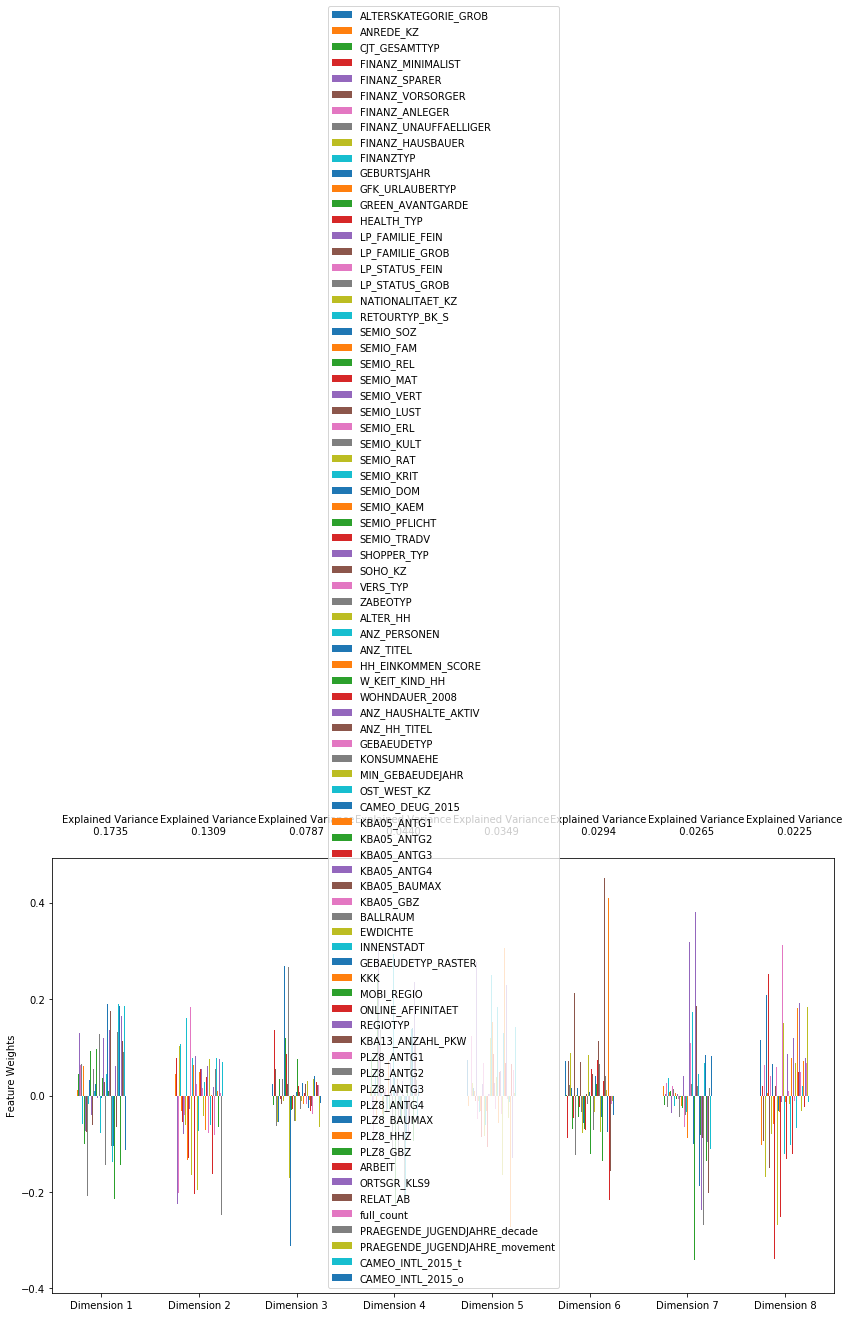

In [104]:
pca_results(df_normalized, pca)

In [105]:
pca3, Y_pca = do_pca(10, customers_normalized)

,Explained Variance,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,full_count,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_t,CAMEO_INTL_2015_o
Dimension 1,0.1576,0.0397,-0.0077,0.1058,-0.0091,-0.2112,0.0203,-0.0049,-0.0040,-0.0219,...,0.0224,-0.1398,0.1140,0.1492,0.1140,-0.0260,-0.0226,-0.0226,0.1791,-0.0646
Dimension 2,0.0946,0.0414,-0.2396,0.0320,0.1297,-0.1109,0.2879,-0.2820,0.2468,0.1979,...,-0.0047,-0.0136,-0.0120,-0.0152,-0.0138,-0.0462,0.3039,0.3039,0.0188,-0.0661
Dimension 3,0.0770,-0.0132,-0.0378,-0.3229,0.0474,0.0553,0.0028,-0.0016,-0.1171,-0.0002,...,0.0275,-0.0666,0.0740,0.1117,0.0769,0.0069,-0.0147,-0.0147,0.0440,-0.0162
Dimension 4,0.0452,0.0029,-0.0122,0.1134,0.0936,0.0658,-0.0225,0.0030,-0.0914,0.0262,...,0.0503,-0.0466,0.2055,0.2866,0.1964,0.0691,0.0172,0.0172,-0.1026,0.0913
Dimension 5,0.0387,-0.0978,0.2318,-0.0382,0.0435,-0.0116,-0.0162,0.0215,0.0411,-0.0643,...,-0.1016,-0.1063,-0.0155,-0.0430,-0.0058,0.0888,0.0384,0.0384,0.1041,-0.0804
Dimension 6,0.0299,-0.0475,0.0531,0.0526,-0.0150,-0.0894,0.0079,0.0084,-0.0246,0.0445,...,0.4019,0.3048,-0.2125,-0.1125,-0.1828,-0.0115,0.0077,0.0077,-0.0683,0.0537
Dimension 7,0.0290,0.1830,-0.2395,0.0308,-0.0096,0.0356,-0.2187,0.2389,-0.1404,-0.2500,...,0.0101,0.0122,-0.0546,-0.0573,-0.0544,0.1349,-0.1801,-0.1801,0.0310,-0.0311
Dimension 8,0.0263,-0.0275,-0.0215,0.0496,-0.0125,-0.0588,-0.0032,-0.0219,0.0042,-0.0276,...,-0.3976,-0.2971,-0.1033,-0.0692,-0.0822,0.0188,-0.0140,-0.0140,-0.1448,0.1600
Dimension 9,0.0226,-0.0128,-0.0121,-0.0729,0.0266,0.0133,0.0221,-0.0347,0.0138,-0.0173,...,0.1778,0.1424,0.0947,0.1221,0.0338,0.0894,0.0367,0.0367,-0.0768,0.1545
Dimension 10,0.0184,-0.0230,0.0051,0.0025,-0.0943,0.1343,0.0092,0.0042,-0.0323,0.0876,...,-0.0532,-0.1591,-0.1942,-0.1023,-0.0471,0.0186,0.0307,0.0307,0.2339,-0.2641


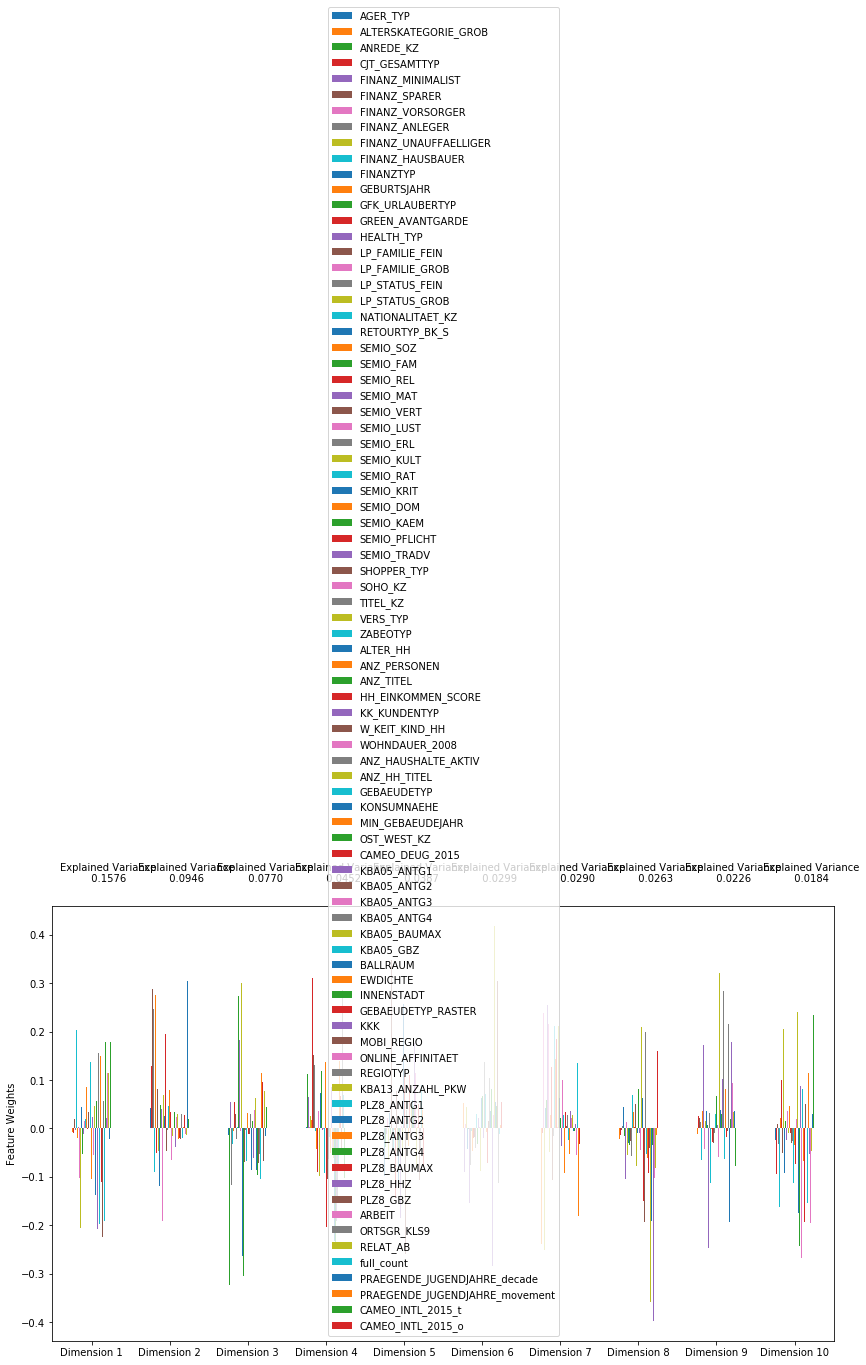

In [106]:
pca_results(customers_normalized, pca3)

In [107]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


### Discussion 3.3: Compare Customer Data to Demographics Data

Here when we review the first principle component's underrepresented data from the general population demographics dataset we can see that MOBI_REGIO with a score of -0.213796 which is related to movement patters of our population is , LP_STATUS_FEIN with a score of -0.209960 this field identifys social status on a fine scale finally LP_STATUS_GROB with a score of  -0.208982, this field identifys social status on a rough scale.

Here reviewing the first principle components data we see that PLZ8_ANTG3 with a score of 0.194121 showing Number of 6-10 family houses in the PLZ8 region was the most significate item, followed by CAMEO_DEUG_2015 with a score of                 0.189796 displaying Wealth / Life Stage Typology, rough scale. Next we can see PLZ8_ANTG4 with a score of                    0.189606 which identifys Number of 10+ family houses in the PLZ8 region. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.